In [1]:
%load_ext autoreload
%autoreload 2

# Processing Sensitivity Analysis Outputs

In [2]:
import os
from pathlib import Path


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
import sys
from omegaconf import OmegaConf
import polars as pl

sys.path.append(str(ROOT))

## Load the Data

In [3]:
experiment_root = ROOT / "data/SA1/SobolSensitivityAnalysisCars-2048"

### Build A Dataframe from Results

In [4]:
results_df_path = experiment_root / "results.parquet"

results_df = pl.read_parquet(results_df_path)
repr_conf = OmegaConf.load(experiment_root / "config.yaml")

In [5]:
print(experiment_root / "results.parquet")

/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-2048/results.parquet


### Build a DataFrame from Sobol Sequence

In [6]:
sample_df = pl.read_parquet(
    experiment_root / "sobol_sequence.parquet", 
).with_row_count("run_id")

### Update the Fuel Amount

In [7]:
from src.sa_helpers.metrics import energy_2_fuel

results_df = results_df.pipe(energy_2_fuel)

In [8]:
results_df.head()

run_id,calibration_passed,total_fuel_l,average_fc,average_speed,average_delay,average_travel_time,delay_ratio,total_vehicles,total_vehicles_emissions,total_energy,total_fuel_l_cropped,cropped_per_vehicle_fuel
u32,bool,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64
0,true,434.4387,8.631884,12.016258,47.119581,99.79109,0.31241,5017,5044,1.2048e10,374.121548,0.074172
1,true,435.284142,8.652845,11.92619,47.451742,100.640016,0.290017,5018,5045,1.2087e10,375.337357,0.074398
2,true,430.910194,8.561929,12.205652,45.251879,97.879195,0.28255,5018,5045,1.1964e10,371.518434,0.073641
3,false,434.143332,8.626967,11.989125,47.59995,100.222798,0.300233,5018,5045,1.2043e10,373.966884,0.074126
4,true,437.042938,8.686262,11.865223,49.022511,101.975409,0.318138,5018,5044,1.2150e10,377.284646,0.074799


In [9]:
results_df[["total_fuel_l_cropped", "cropped_per_vehicle_fuel"]].quantile(0.95)

total_fuel_l_cropped,cropped_per_vehicle_fuel
f64,f64
380.95772,0.075571


### Join the DataFrame

In [10]:
results_df = results_df.join(sample_df, on="run_id")
results_df.head()

run_id,calibration_passed,total_fuel_l,average_fc,average_speed,average_delay,average_travel_time,delay_ratio,total_vehicles,total_vehicles_emissions,total_energy,total_fuel_l_cropped,cropped_per_vehicle_fuel,RandomSeed,Tau,TauDev,TauDist,Accel,AccelDev,AccelDist,Decel,DecelDev,DecelDist,minGap,minGapDev,minGapDist,speedFactor,speedDev,speedFactorDist,impatience,impatienceDev,lcStrategic,lcStrategicDev,lcAssertive,lcAssertiveDev
u32,bool,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,true,434.4387,8.631884,12.016258,47.119581,99.79109,0.31241,5017,5044,1.2048e10,374.121548,0.074172,43102.947436,1.760535,0.473509,0.16037,1.336291,0.436143,2.093328,3.034661,1.631201,0.343975,2.556586,1.121535,1.14318,1.048509,0.176147,0.725901,0.088216,0.103481,1.107027,0.247048,1.165676,0.136753
1,true,435.284142,8.652845,11.92619,47.451742,100.640016,0.290017,5018,5045,1.2087e10,375.337357,0.074398,66979.168542,1.760535,0.473509,0.16037,1.336291,0.436143,2.093328,3.034661,1.631201,0.343975,2.556586,1.121535,1.14318,1.048509,0.176147,0.725901,0.088216,0.103481,1.107027,0.247048,1.165676,0.136753
2,true,430.910194,8.561929,12.205652,45.251879,97.879195,0.28255,5018,5045,1.1964e10,371.518434,0.073641,43102.947436,1.515191,0.473509,0.16037,1.336291,0.436143,2.093328,3.034661,1.631201,0.343975,2.556586,1.121535,1.14318,1.048509,0.176147,0.725901,0.088216,0.103481,1.107027,0.247048,1.165676,0.136753
3,false,434.143332,8.626967,11.989125,47.59995,100.222798,0.300233,5018,5045,1.2043e10,373.966884,0.074126,43102.947436,1.760535,0.348843,0.16037,1.336291,0.436143,2.093328,3.034661,1.631201,0.343975,2.556586,1.121535,1.14318,1.048509,0.176147,0.725901,0.088216,0.103481,1.107027,0.247048,1.165676,0.136753
4,true,437.042938,8.686262,11.865223,49.022511,101.975409,0.318138,5018,5044,1.2150e10,377.284646,0.074799,43102.947436,1.760535,0.473509,1.673168,1.336291,0.436143,2.093328,3.034661,1.631201,0.343975,2.556586,1.121535,1.14318,1.048509,0.176147,0.725901,0.088216,0.103481,1.107027,0.247048,1.165676,0.136753


## Perform Sensitivity Analysis

In [11]:
from SALib.analyze import sobol
from SALib.sample import sobol as sobol_sample
from sumo_pipelines.blocks.producers.config import SobolSequenceConfig

In [12]:
problem = SobolSequenceConfig.build_sobol_dict(repr_conf.Blocks.SobolSequenceConfig)
second_order = repr_conf.Blocks.SobolSequenceConfig.calc_second_order


def get_sa_results(results_df, problem, column, second_order=False):
    return sobol.analyze(
        problem, results_df[column].to_numpy(), calc_second_order=second_order
    )

### Verify that Everything is in Right Order

In [13]:
import numpy as np

sobol_sampled = sobol_sample.sample(
    problem,
    N=repr_conf.Blocks.SobolSequenceConfig.N,
    calc_second_order=second_order,
    seed=repr_conf.Metadata.random_seed,
)

assert np.allclose(sobol_sampled, sample_df[problem["names"]].to_numpy())

In [14]:
repr_conf.Blocks.SobolSequenceConfig.N, second_order, len(problem["names"]), repr_conf.Blocks.SobolSequenceConfig.N * (len(problem["names"]) + 2)

(2048, False, 22, 49152)

In [15]:
sobol_sampled.shape

(49152, 22)

### Perform Sensitivity Analysis

In [16]:
target_cols = set(results_df.columns).intersection(
    set(repr_conf.Pipeline.pipeline[0].consumers[8].config.keys())
) | set(
    [
        "cropped_per_vehicle_fuel",
        "total_fuel_l_cropped",
    ]
)

results = {}

for col in target_cols:
    results[col] = get_sa_results(
        results_df,
        problem,
        col,
        second_order=second_order,
    )

In [17]:
# build the results dataframe for S1 and ST
sobol_df = pl.DataFrame(
    {
        "names": problem["names"],
        **{
            f"{col}_{sa_type}": results[col][sa_type]
            for col in target_cols
            for sa_type in ["S1", "ST", "S1_conf", "ST_conf"]
        },
    }
)

In [18]:
sobol_df.head()

names,cropped_per_vehicle_fuel_S1,cropped_per_vehicle_fuel_ST,cropped_per_vehicle_fuel_S1_conf,cropped_per_vehicle_fuel_ST_conf,total_fuel_l_cropped_S1,total_fuel_l_cropped_ST,total_fuel_l_cropped_S1_conf,total_fuel_l_cropped_ST_conf,average_delay_S1,average_delay_ST,average_delay_S1_conf,average_delay_ST_conf,delay_ratio_S1,delay_ratio_ST,delay_ratio_S1_conf,delay_ratio_ST_conf,average_speed_S1,average_speed_ST,average_speed_S1_conf,average_speed_ST_conf,total_vehicles_S1,total_vehicles_ST,total_vehicles_S1_conf,total_vehicles_ST_conf,average_fc_S1,average_fc_ST,average_fc_S1_conf,average_fc_ST_conf,total_fuel_l_S1,total_fuel_l_ST,total_fuel_l_S1_conf,total_fuel_l_ST_conf,average_travel_time_S1,average_travel_time_ST,average_travel_time_S1_conf,average_travel_time_ST_conf
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""RandomSeed""",0.01915,0.046511,0.013678,0.004054,0.018971,0.046391,0.014471,0.004053,0.002645,0.013885,0.006732,0.001109,0.01627,0.057006,0.012156,0.004308,-0.001037,0.008968,0.005125,0.000718,0.003424,0.512525,0.048252,0.098702,0.012948,0.035699,0.012658,0.003275,0.013325,0.03464,0.009825,0.002915,0.000338,0.013969,0.006818,0.001144
"""Tau""",0.093123,0.127048,0.020604,0.010231,0.095671,0.130689,0.021419,0.012032,0.149015,0.156207,0.024538,0.011131,0.127055,0.156185,0.025539,0.012244,0.129679,0.135046,0.02172,0.009991,-0.019677,0.384394,0.040174,0.088785,0.109511,0.131491,0.021681,0.01078,0.100943,0.122016,0.023249,0.009136,0.131092,0.140408,0.02517,0.008166
"""TauDev""",0.000722,0.019772,0.007814,0.002105,0.000679,0.019779,0.00819,0.002146,0.000018,0.007364,0.004411,0.000849,-0.000797,0.01981,0.007893,0.002005,-0.000441,0.002448,0.003278,0.000262,-0.035077,0.291256,0.033818,0.065493,-0.001032,0.014662,0.006942,0.001437,-0.001106,0.013896,0.006637,0.001375,-0.000146,0.006807,0.004554,0.00075
"""TauDist""",-0.005633,0.022284,0.00955,0.002044,-0.005043,0.02232,0.010024,0.001994,0.00641,0.007522,0.005289,0.000854,0.005848,0.020001,0.008284,0.002178,-0.000035,0.004084,0.004367,0.00041,0.012006,0.298255,0.035466,0.068115,-0.007807,0.017845,0.009757,0.001744,-0.008407,0.017039,0.007869,0.001822,0.005592,0.007231,0.005214,0.000836
"""Accel""",0.038695,0.111713,0.018897,0.011975,0.035281,0.109501,0.021114,0.011298,0.553472,0.59102,0.052245,0.033336,0.496047,0.555122,0.04399,0.037539,0.431297,0.447213,0.035941,0.026345,0.0061,0.194889,0.019073,0.056261,0.151893,0.205379,0.028507,0.015113,0.165242,0.217059,0.027836,0.01717,0.492039,0.527606,0.035419,0.034106


## Tables of Results

In [19]:
col = "average_travel_time"

sobol_df.sort(f"{col}_ST", descending=True).select(
    "names", pl.col(f"^{col}.*$")
).filter(pl.col(f"{col}_ST") > 0.05)

names,average_travel_time_S1,average_travel_time_ST,average_travel_time_S1_conf,average_travel_time_ST_conf
str,f64,f64,f64,f64
"""Accel""",0.492039,0.527606,0.035419,0.034106
"""Decel""",0.147235,0.184271,0.024158,0.013094
"""Tau""",0.131092,0.140408,0.02517,0.008166
"""speedFactor""",0.068271,0.105179,0.018382,0.009111
"""impatience""",0.032427,0.054135,0.014726,0.004509


In [20]:
col = "average_delay"

sobol_df.sort(f"{col}_ST", descending=True).select(
    "names", pl.col(f"^{col}.*$")
).filter(pl.col(f"{col}_ST") > 0.05)

names,average_delay_S1,average_delay_ST,average_delay_S1_conf,average_delay_ST_conf
str,f64,f64,f64,f64
"""Accel""",0.553472,0.59102,0.052245,0.033336
"""Decel""",0.168181,0.206547,0.028497,0.014849
"""Tau""",0.149015,0.156207,0.024538,0.011131
"""impatience""",0.038082,0.059552,0.014446,0.00602


In [21]:
col = "delay_ratio"

sobol_df.sort(f"{col}_ST", descending=True).select(
    "names", pl.col(f"^{col}.*$")
).filter(pl.col(f"{col}_ST") > 0.05)

names,delay_ratio_S1,delay_ratio_ST,delay_ratio_S1_conf,delay_ratio_ST_conf
str,f64,f64,f64,f64
"""Accel""",0.496047,0.555122,0.04399,0.037539
"""Decel""",0.154843,0.200872,0.026873,0.015769
"""Tau""",0.127055,0.156185,0.025539,0.012244
"""impatience""",0.061813,0.120597,0.020999,0.013971
"""RandomSeed""",0.01627,0.057006,0.012156,0.004308


In [22]:
col = "cropped_per_vehicle_fuel"

sobol_df.sort(f"{col}_ST", descending=True).select(
    "names", pl.col(f"^{col}.*$")
).filter(pl.col(f"{col}_ST") > 0.05)

names,cropped_per_vehicle_fuel_S1,cropped_per_vehicle_fuel_ST,cropped_per_vehicle_fuel_S1_conf,cropped_per_vehicle_fuel_ST_conf
str,f64,f64,f64,f64
"""speedFactor""",0.268393,0.452678,0.035901,0.040264
"""Decel""",0.178748,0.240299,0.028552,0.022379
"""speedDev""",0.021353,0.152399,0.025596,0.01674
"""impatience""",0.073504,0.133322,0.021193,0.01179
"""Tau""",0.093123,0.127048,0.020604,0.010231
"""Accel""",0.038695,0.111713,0.018897,0.011975
"""minGap""",0.057048,0.106309,0.017754,0.012503


## Plot the Results

In [23]:
from src.plotting.plots import plot_bars
from src.plotting.helpers import plotly_2_image
from src.plotting.latex import ORDERED_VARIABLES

sobol_df = sobol_df.with_columns(
    pl.col("names").map_dict(ORDERED_VARIABLES).alias("order")
)

/tmp/ipykernel_922635/2577240236.py:6: DeprecationWarning: `map_dict` is deprecated. It has been renamed to `replace`. The default behavior has changed to keep any values not present in the mapping unchanged. Pass `default=None` to keep existing behavior.
  pl.col("names").map_dict(ORDERED_VARIABLES).alias("order")


cropped_per_vehicle_fuel
average_travel_time
average_delay
delay_ratio


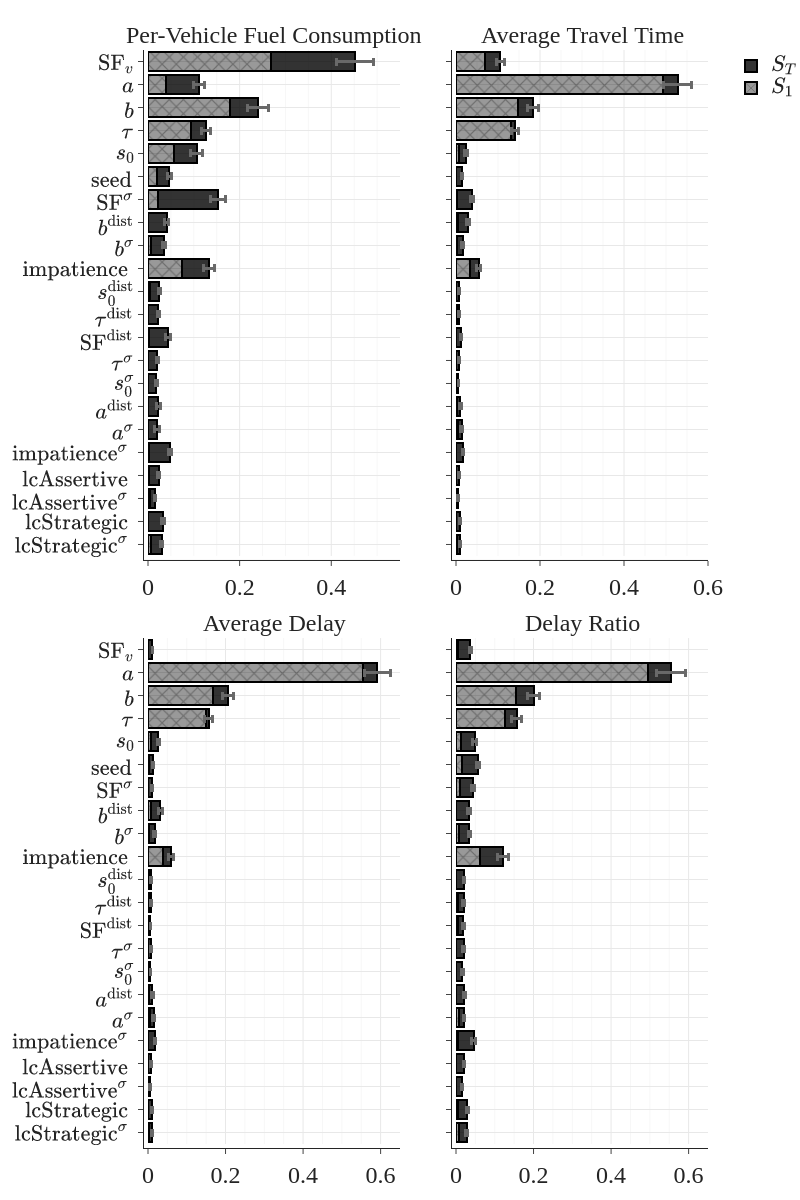

In [24]:
fig = plot_bars(
    sobol_df,
    plot_columns=[
        "cropped_per_vehicle_fuel",
        "average_travel_time",
        # "average_fc",
        "average_delay",
        "delay_ratio",
    ],
    pretty_columns=[
        "Per-Vehicle Fuel Consumption",
        "Average Travel Time",
        "Average Delay",
        "Delay Ratio",
    ],
    sort_columns=["order"],
    variable_column="names",
    use_latex=True,
)

plotly_2_image(fig)

cropped_per_vehicle_fuel
average_travel_time
average_delay
delay_ratio


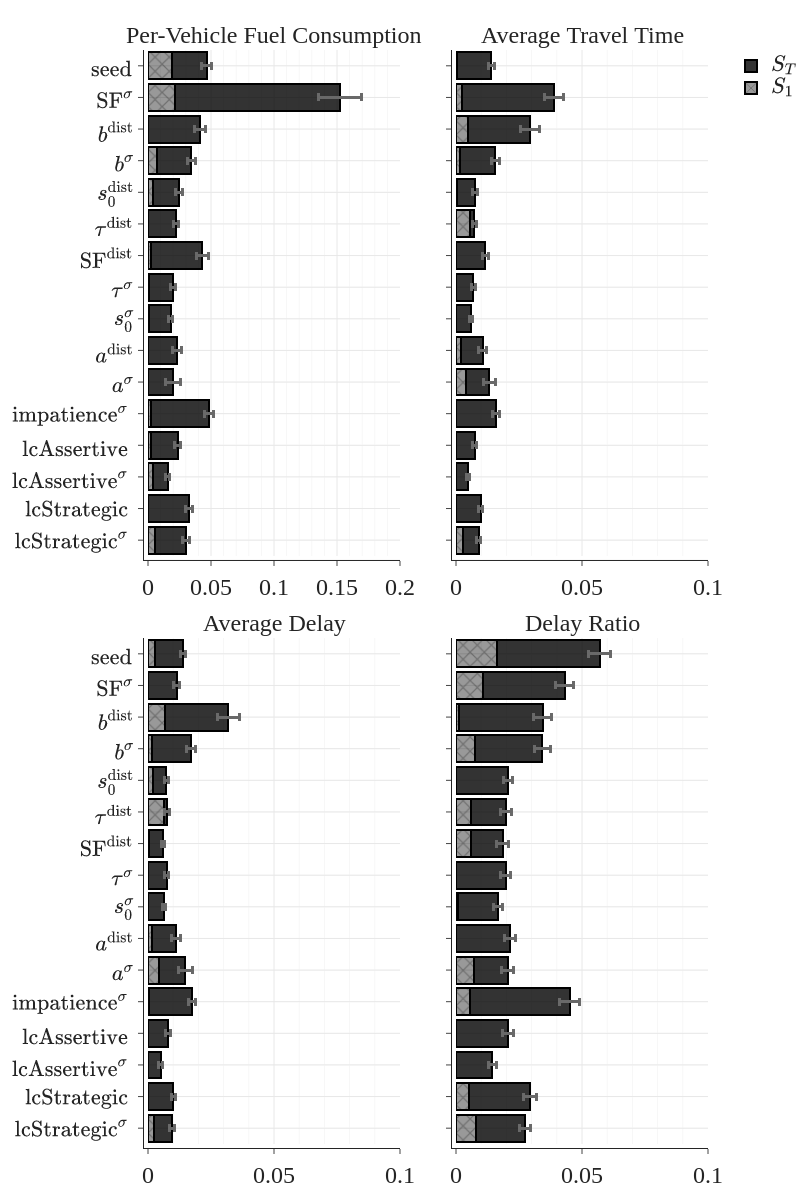

In [25]:
fig = plot_bars(
    sobol_df.filter(
        ~pl.col("names").is_in(
            ["speedFactor", "minGap", "Accel", "Decel", "Tau", "impatience"]
        )
    ),
    plot_columns=[
        "cropped_per_vehicle_fuel",
        "average_travel_time",
        # "average_fc",
        "average_delay",
        "delay_ratio",
    ],
    pretty_columns=[
        "Per-Vehicle Fuel Consumption",
        "Average Travel Time",
        "Average Delay",
        "Delay Ratio",
    ],
    sort_columns=["order"],
    variable_column="names",
    use_latex=True,
)

plotly_2_image(fig)

### Looking Fuel Parallel Coordinates

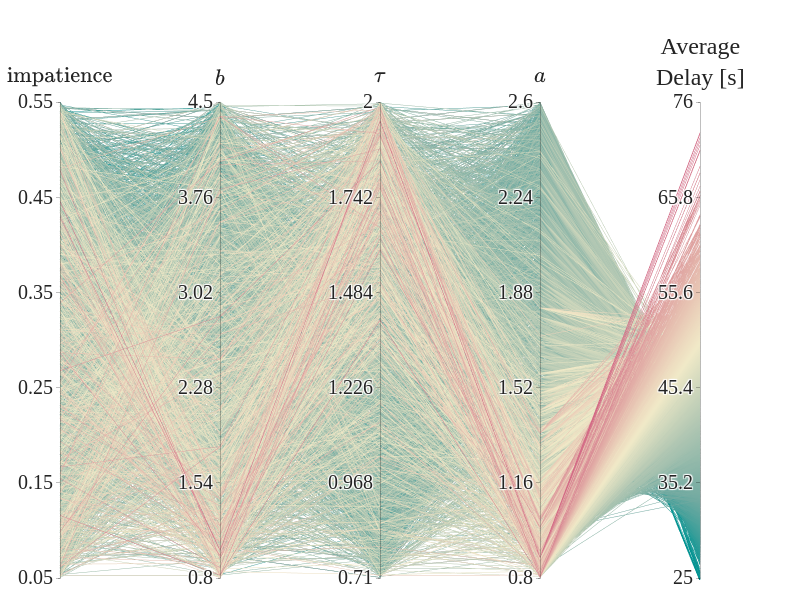

In [26]:
from src.plotting.plots import plot_parallel_coordinates


fig = plot_parallel_coordinates(
    results_df=results_df,
    plot_cols=["impatience", "Decel", "Tau", "Accel"],
    metric_col="average_delay",
    pretty_metric="Average<br>Delay [s]",
)


# html looks nicer but doesn't render in github
# fig.write_html("delay.html", include_plotlyjs="cdn", include_mathjax="cdn")
plotly_2_image(fig, width=800, height=600, scale=1)


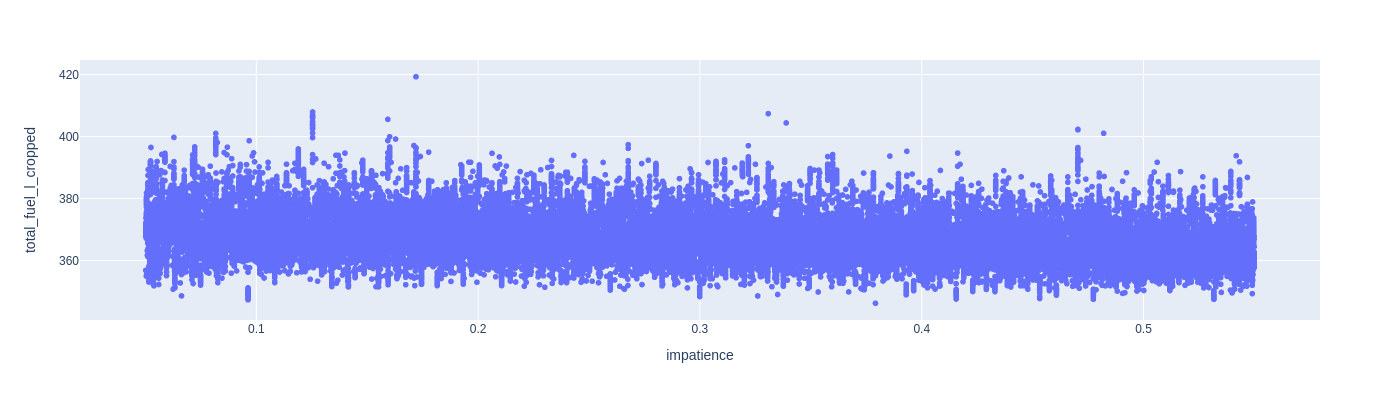

In [27]:
import plotly.express as px
import plotly.graph_objects as go


# scatter plot decel vs. total fuel consumption
fig = px.scatter(
    results_df,  # .filter((pl.col("speedFactor") - 1.15).abs() < 0.05),
    x="impatience",
    y="total_fuel_l_cropped",
)


plotly_2_image(fig, width=1400, height=400, scale=1)

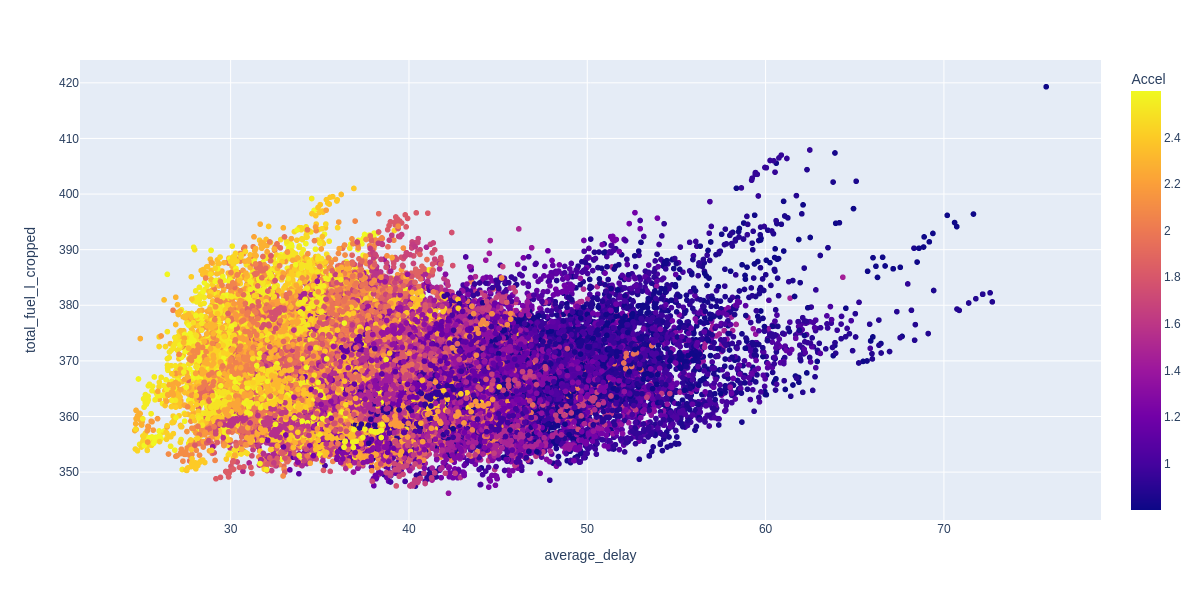

In [28]:
import plotly.express as px
import plotly.graph_objects as go


# scatter plot decel vs. total fuel consumption
fig = px.scatter(
    results_df,  # .filter((pl.col("speedFactor") - 1.15).abs() < 0.05),
    x="average_delay",
    y="total_fuel_l_cropped",
    color="Accel",
    # color_continuous_scale=px.colors.diverging.Tealrose,
)


plotly_2_image(fig, width=1200, height=600, scale=1)

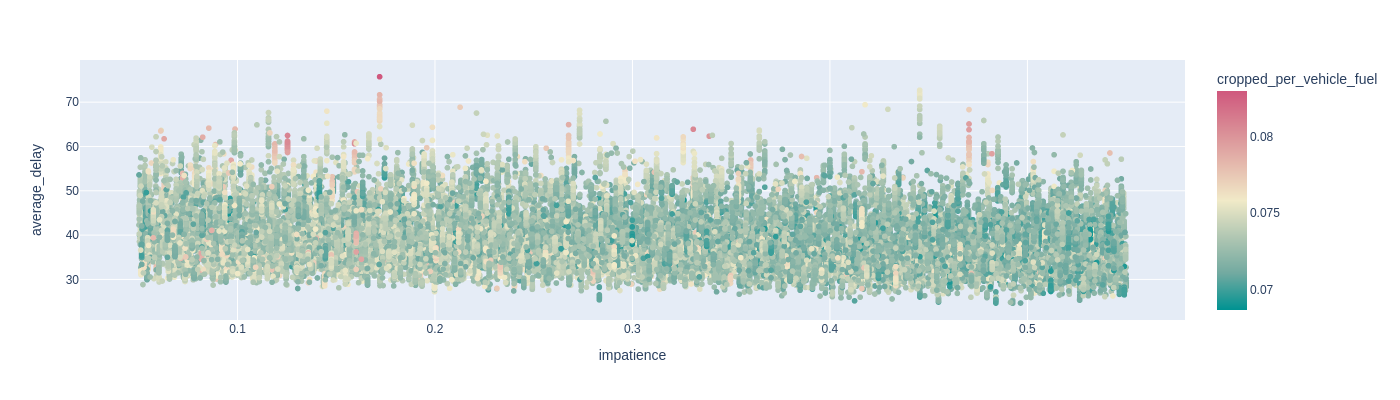

In [29]:
import plotly.express as px
import plotly.graph_objects as go


# scatter plot decel vs. total fuel consumption
fig = px.scatter(
    results_df,  # .filter((pl.col("speedFactor") - 1.15).abs() < 0.05),
    x="impatience",
    y="average_delay",
    color="cropped_per_vehicle_fuel",
    color_continuous_scale=px.colors.diverging.Tealrose,
)


plotly_2_image(fig, width=1400, height=400, scale=1)

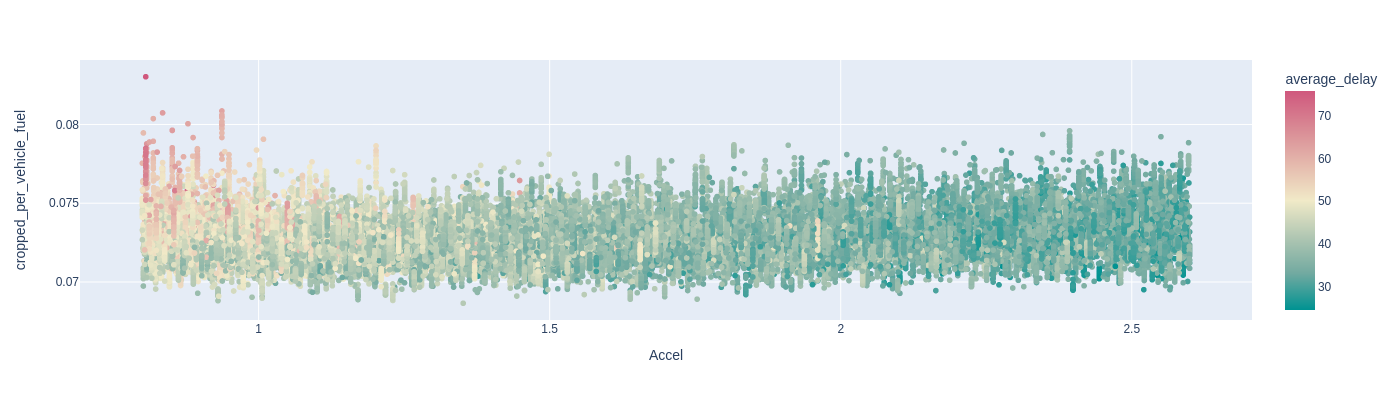

In [30]:
import plotly.express as px
import plotly.graph_objects as go


# scatter plot decel vs. total fuel consumption
fig = px.scatter(
    results_df,  # .filter((pl.col("speedFactor") - 1.15).abs() < 0.05),
    x="Accel",
    y="cropped_per_vehicle_fuel",
    color="average_delay",
    color_continuous_scale=px.colors.diverging.Tealrose,
)


plotly_2_image(fig, width=1400, height=400, scale=1)

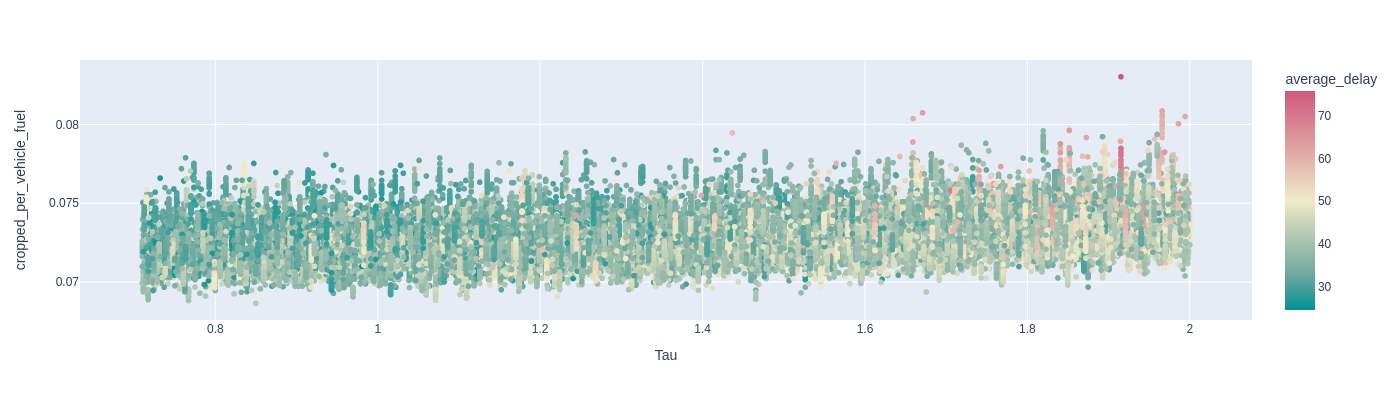

In [31]:
import plotly.express as px
import plotly.graph_objects as go


# scatter plot decel vs. total fuel consumption
fig = px.scatter(
    results_df,  # .filter((pl.col("speedFactor") - 1.15).abs() < 0.05),
    x="Tau",
    y="cropped_per_vehicle_fuel",
    color="average_delay",
    color_continuous_scale=px.colors.diverging.Tealrose,
)


plotly_2_image(fig, width=1400, height=400, scale=1)

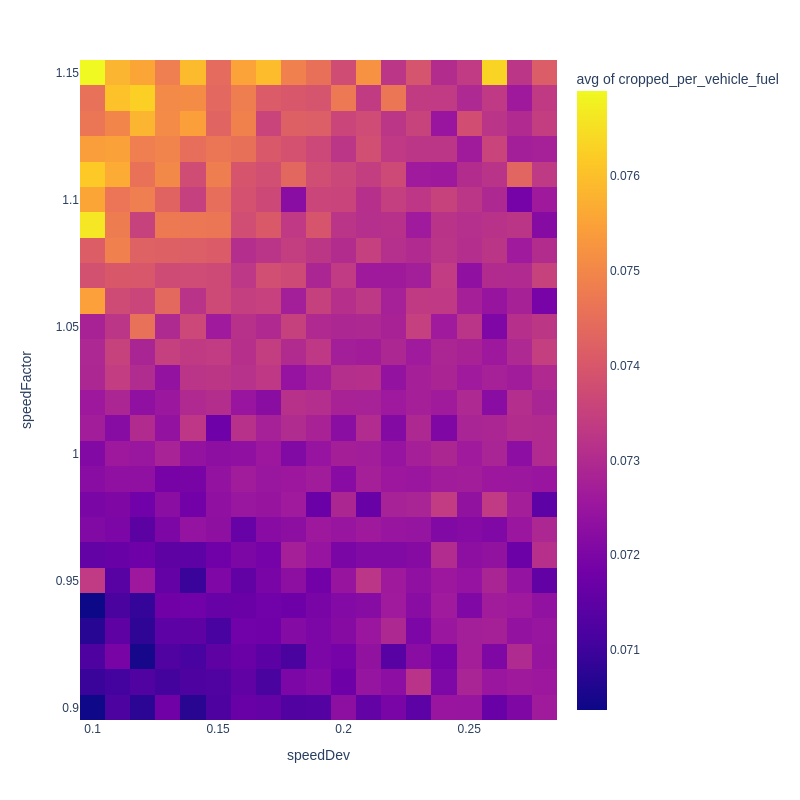

In [32]:
fig = px.density_heatmap(
    results_df.to_pandas(),
    x="speedDev",
    y="speedFactor",
    z="cropped_per_vehicle_fuel",
    histfunc="avg",
)

plotly_2_image(fig, width=800, height=800, scale=1)

## Distribution of Outputs

In [33]:
results_df["total_fuel_l_cropped"].skew(), results_df["total_fuel_l_cropped"].kurtosis()

(0.5309823901019207, 0.5576396838066997)

In [34]:
results_df["average_travel_time"].skew(), results_df["average_travel_time"].kurtosis()

(0.6188056085989557, 0.5006361709418119)

In [35]:
results_df["delay_ratio"].skew(), results_df["delay_ratio"].kurtosis()

(0.7246352375096535, 0.6108411070929574)

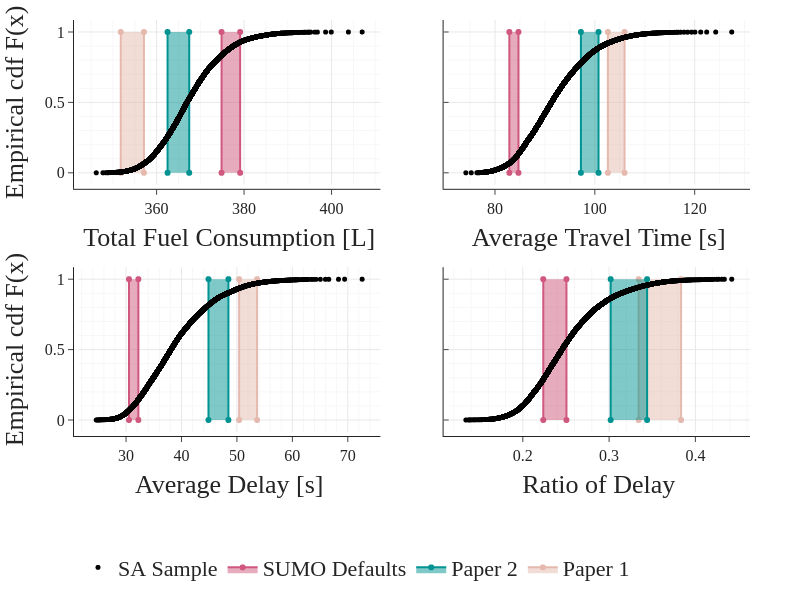

In [36]:
from src.plotting.plots import plot_ecdfs


def open_res_df(path):
    return (
        pl.read_parquet(path / "results.parquet")
        .pipe(energy_2_fuel)
    )


fig = plot_ecdfs(
    results_df=results_df,
    plot_columns=[
        "total_fuel_l_cropped",
        "average_travel_time",
        "average_delay",
        "delay_ratio",
    ],
    pretty_columns=[
        "Total Fuel Consumption [L]",
        "Average Travel Time [s]",
        "Average Delay [s]",
        "Ratio of Delay",
    ],
    paper_mapping={
        "Paper 1": (open_res_df(ROOT / "data/LiteratureDefaults/ShanghaiPaper"), "rgba(229, 185, 173, 1)"),
        "Paper 2": (open_res_df(ROOT / "data/LiteratureDefaults/CorrPaper"), "rgba(0, 147, 146, 1)"),
        "SUMO Defaults": (open_res_df(ROOT / "data/LiteratureDefaults/SumoDefaults"), "rgba(208, 88, 126, 1)"),
    },
)

plotly_2_image(fig, width=800, height=600, scale=1)

### Statistical Analysis

In [39]:
from scipy.stats import pearsonr

print(
    pearsonr(
        results_df["Decel"].to_numpy(), results_df["total_fuel_l_cropped"].to_numpy()
    )
)

PearsonRResult(statistic=0.41454951210587104, pvalue=0.0)


In [41]:
from scipy.stats import spearmanr

print(
    spearmanr(
        results_df["Decel"].to_numpy(), results_df["total_fuel_l_cropped"].to_numpy()
    ),
    results_df.shape[0] - 2,
)

SignificanceResult(statistic=0.41792550765398434, pvalue=0.0) 49150


In [39]:
failure_df = results_df.filter(~pl.col("calibration_passed"))
pass_df = results_df.filter(pl.col("calibration_passed"))

In [40]:
import scipy.stats as stats

stats.ks_2samp(failure_df["average_delay"], pass_df["average_delay"])

KstestResult(statistic=0.0931484683979571, pvalue=3.1015896144288522e-06, statistic_location=37.729495815065775, statistic_sign=-1)

In [41]:
stats.ks_2samp(failure_df["total_fuel_l_cropped"], pass_df["total_fuel_l_cropped"])

KstestResult(statistic=0.04604796836304281, pvalue=0.07526915587230532, statistic_location=370.89116799056586, statistic_sign=1)

In [42]:
stats.ks_2samp(failure_df["average_travel_time"], pass_df["average_travel_time"])

KstestResult(statistic=0.07987049917295008, pvalue=0.00010682286330093482, statistic_location=89.61402949382224, statistic_sign=-1)

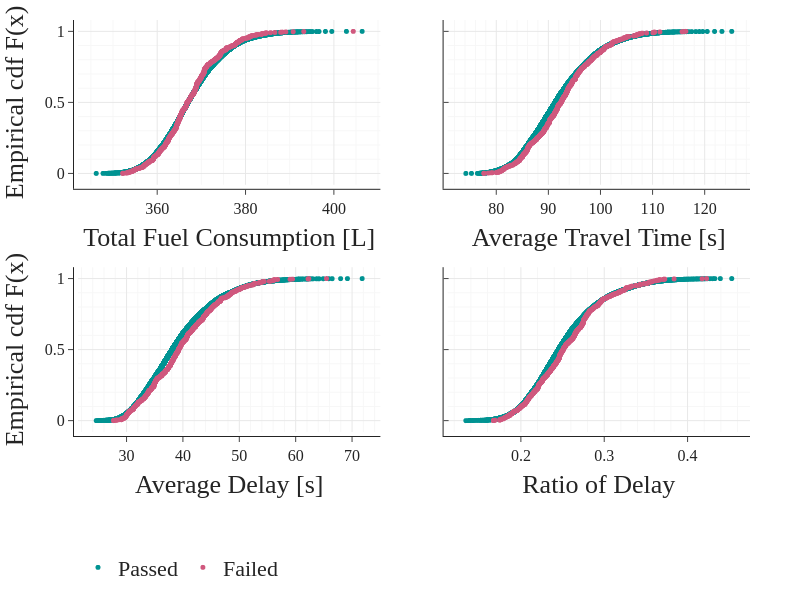

In [45]:
# test to see if the failure_df is statistically different from the success_df
import scipy.stats as stats

stats.ks_2samp(failure_df["average_delay"], pass_df["average_delay"])

# plot the two
fig = plot_ecdfs(
    plot_columns=[
        "total_fuel_l_cropped",
        "average_travel_time",
        "average_delay",
        "delay_ratio",
    ],
    pretty_columns=[
        "Total Fuel Consumption [L]",
        "Average Travel Time [s]",
        "Average Delay [s]",
        "Ratio of Delay",
    ],
    ecdf_mapping={
        "Passed": (pass_df, "rgba(0, 147, 146, 1)"),
        "Failed": (failure_df, "rgba(208, 88, 126, 1)"),
    },
)

plotly_2_image(fig, width=800, height=600, scale=1)